## Quick regression and random forest fits

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [11]:
socioecon = pd.read_csv(
    "./data/rawData/socio_economic.csv"
)

socioecon.columns

Index(['Geography', 'Median_Household_Income', 'Poverty_Population',
       'Unemployed_Population', 'Per_Capita_Income', 'SNAP_Recipients',
       'Total_Pop_Health_Insurance', 'Uninsured_Population',
       'Medicaid_Coverage', 'Medicare_Coverage', 'Private_Insurance_Coverage',
       'High_School_Graduates', 'Bachelor_Degree_Holders',
       'Less_than_High_School', 'Households_No_Vehicle', 'Commute_Time',
       'Public_Transit_Usage', 'Renter_Occupied_Housing',
       'Rent_as_Income_Percentage', 'Overcrowded_Housing',
       'Elderly_Population', 'Children_Population', 'White_Population',
       'Black_Population', 'Disability_Population',
       'Limited_English_Proficiency', 'Households_No_Internet', 'state',
       'county', 'tract', 'GEOID'],
      dtype='object')

### Using "Uninsured_Population" as the target variable

*Rationale*: this is the best proxy indicator for "lack of healthcare accessibility," which is the main thing we want to measure.

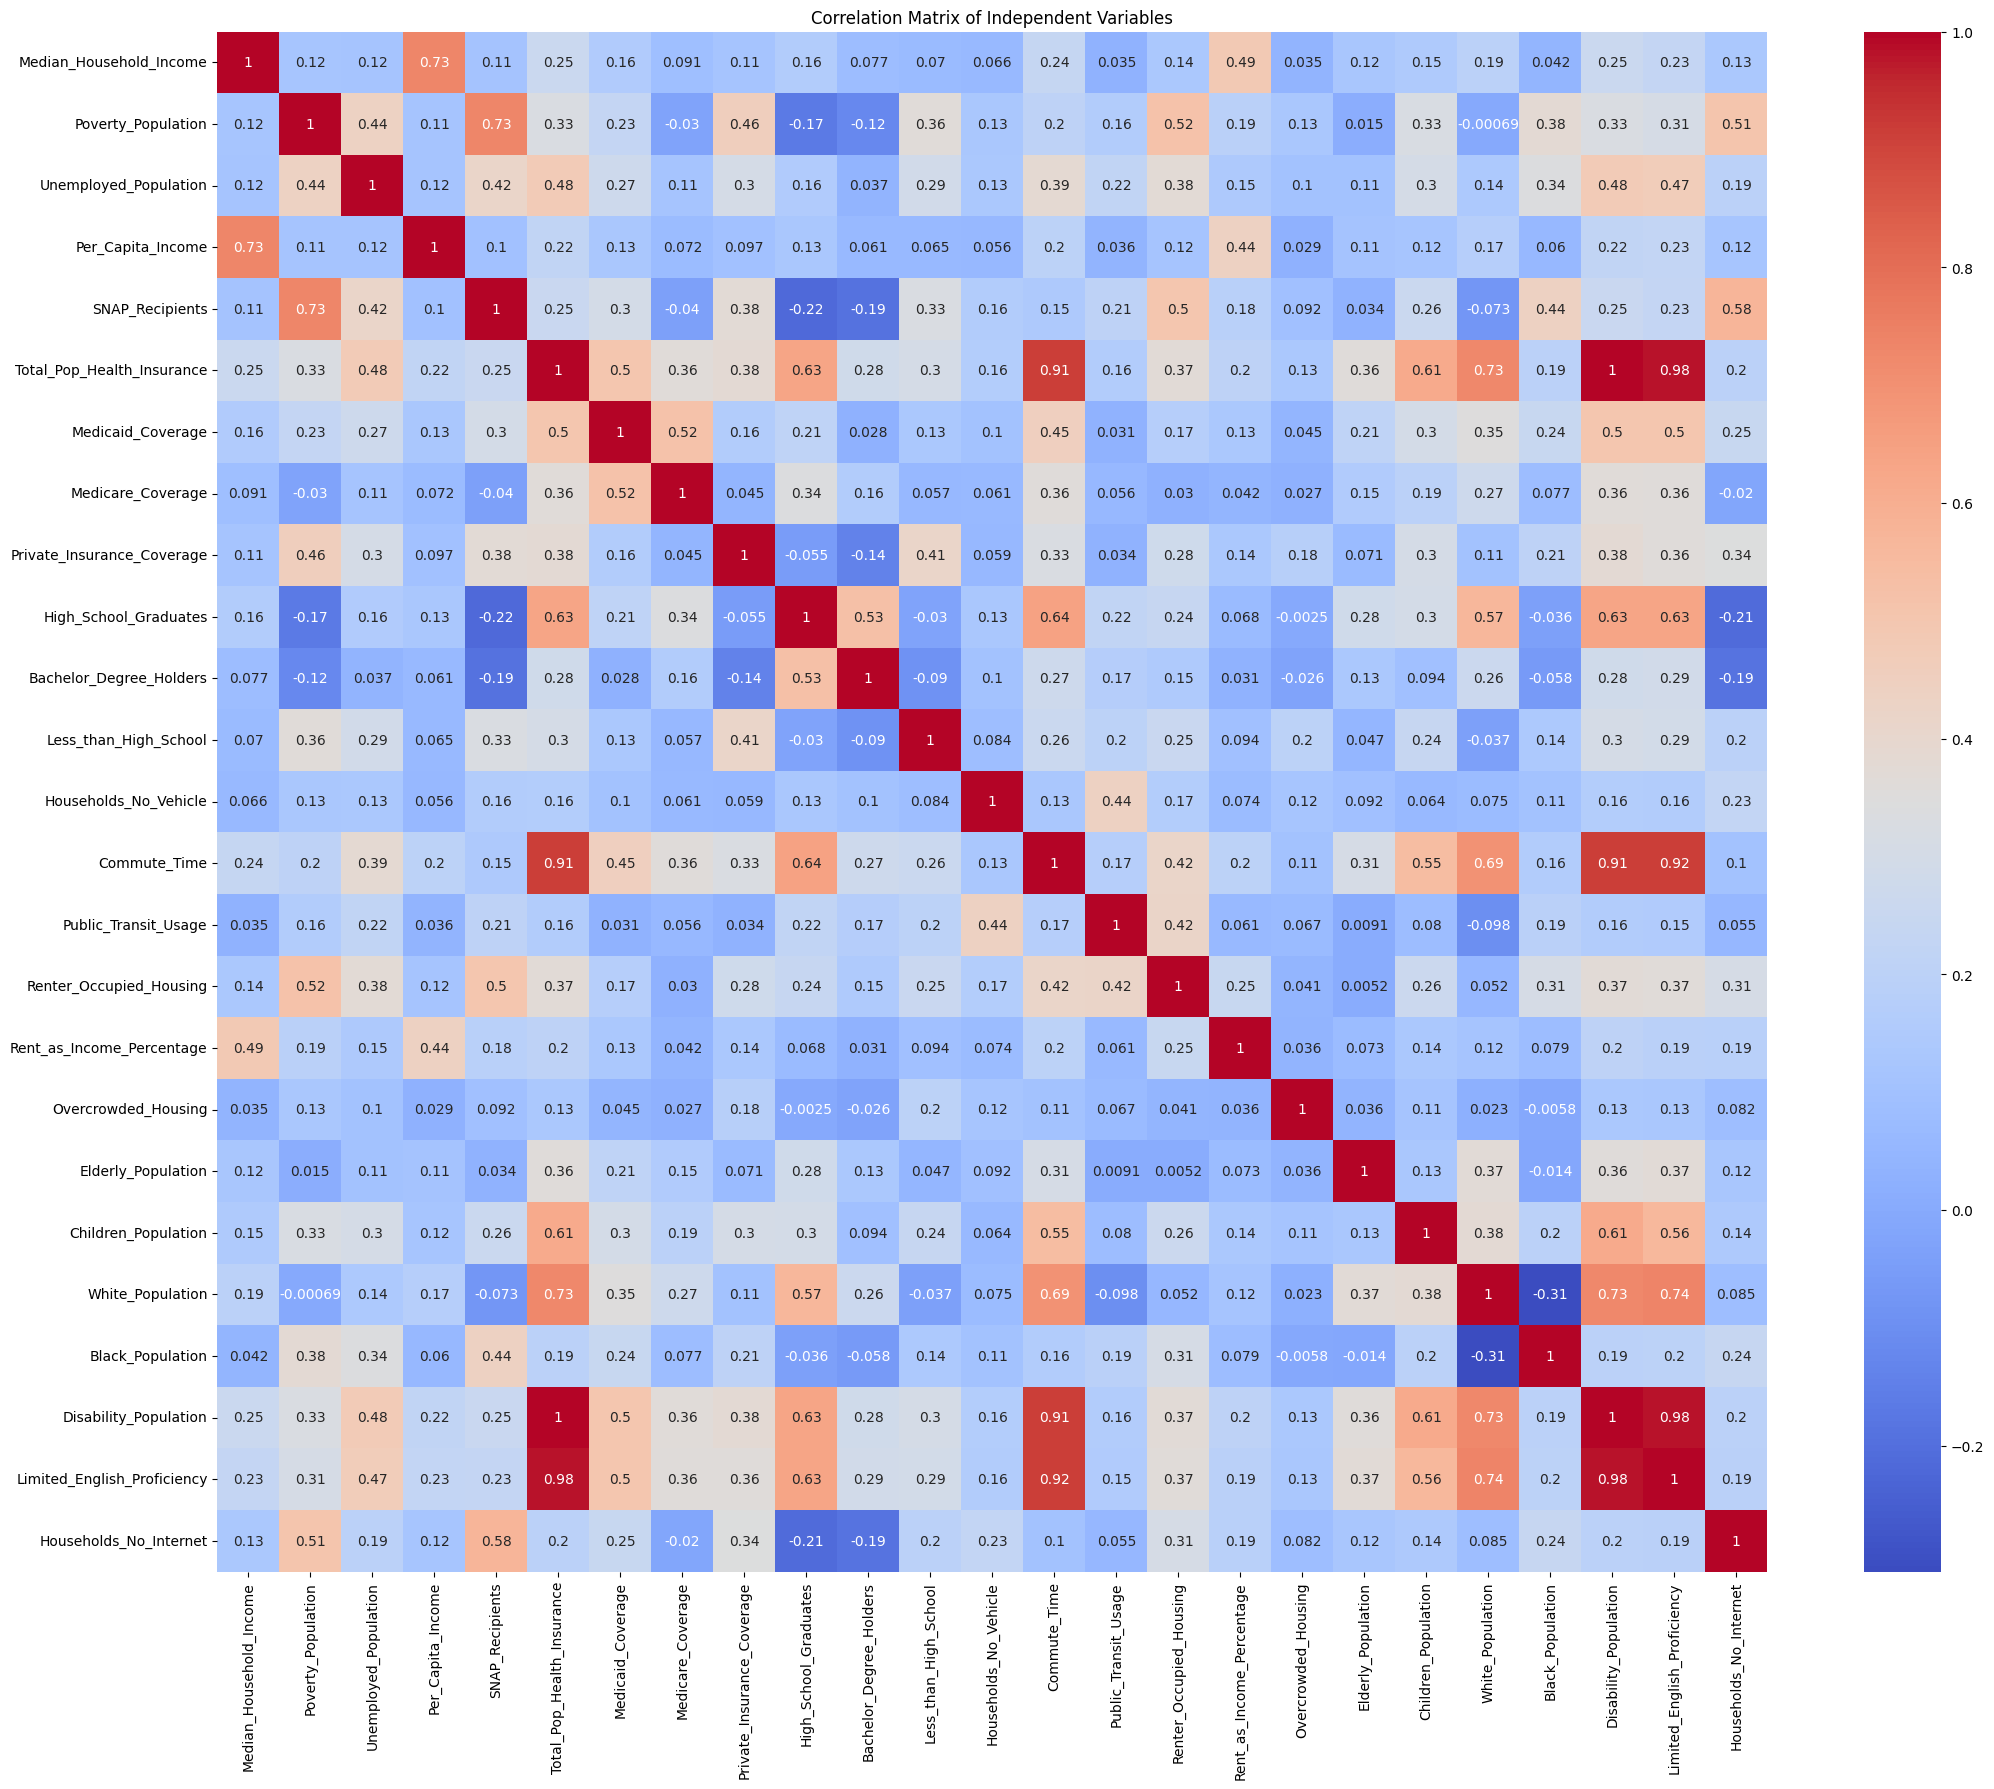

In [37]:
exclude_cols = ['Uninsured_Population', 'state', 'county', 'tract', 'GEOID', 'Geography']
# Create a new DataFrame excluding the specified columns
socioecon_filtered = socioecon.drop(columns=exclude_cols)

# Generate the correlation matrix
corr_matrix = socioecon_filtered.corr()

# Plot the heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Independent Variables")
plt.show()

In [19]:
# Candidate predictors: all columns not excluded
predictors = [col for col in socioecon.columns if col not in exclude_cols]

# Drop rows with missing values in the candidate predictors and target
cols_of_interest = predictors + ['Uninsured_Population']
socioecon_clean = socioecon.dropna(subset=cols_of_interest)

# Function to compute VIF for a list of predictors in a given DataFrame
def calculate_vif(df, predictors_list):
    X = df[predictors_list].values
    vif_data = pd.DataFrame({
        'feature': predictors_list,
        'VIF': [variance_inflation_factor(X, i) for i in range(len(predictors_list))]
    })
    return vif_data

# Calculate initial VIF values
vif_initial = calculate_vif(socioecon_clean, predictors)
print("Initial VIF values:")
print(vif_initial)

# Iteratively remove predictors with VIF above the threshold (e.g., 5)
threshold = 10.0
predictors_reduced = predictors.copy()

while True:
    vif_df = calculate_vif(socioecon_clean, predictors_reduced)
    max_vif = vif_df['VIF'].max()
    if max_vif > threshold:
        feature_to_remove = vif_df.sort_values('VIF', ascending=False)['feature'].iloc[0]
        print(f"Removing '{feature_to_remove}' with VIF = {max_vif:.2f}")
        predictors_reduced.remove(feature_to_remove)
    else:
        break

print("\nFinal set of predictors after VIF-based removal:")
print(predictors_reduced)
print("\nFinal VIF values:")
print(calculate_vif(socioecon_clean, predictors_reduced))

# Prepare data for regression using the cleaned DataFrame
X = socioecon_clean[predictors_reduced]
y = socioecon_clean['Uninsured_Population']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Ridge regression using cross-validation to select the best regularization strength
ridge = RidgeCV(alphas=[0.1, 0.5, 1.0, 10, 50, 100, 20000], cv=5)
ridge.fit(X_train, y_train)
print("\nOptimal alpha from RidgeCV:", ridge.alpha_)

# Evaluate the Ridge model on the test set
y_pred = ridge.predict(X_test)
print("Test R^2:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Initial VIF values:
                        feature         VIF
0       Median_Household_Income    2.448508
1            Poverty_Population    6.887516
2         Unemployed_Population    3.939917
3             Per_Capita_Income    2.296329
4               SNAP_Recipients    6.301663
5    Total_Pop_Health_Insurance         inf
6             Medicaid_Coverage    5.098460
7             Medicare_Coverage    2.372650
8    Private_Insurance_Coverage    3.269476
9         High_School_Graduates    9.931406
10      Bachelor_Degree_Holders    2.060804
11        Less_than_High_School    2.354508
12        Households_No_Vehicle    1.811977
13                 Commute_Time   45.752564
14         Public_Transit_Usage    1.920652
15      Renter_Occupied_Housing    6.130049
16    Rent_as_Income_Percentage    1.432376
17          Overcrowded_Housing    1.189049
18           Elderly_Population    2.689374
19          Children_Population    4.449825
20             White_Population   27.074873
21          

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing 'Total_Pop_Health_Insurance' with VIF = inf
Removing 'Disability_Population' with VIF = 233.73
Removing 'Limited_English_Proficiency' with VIF = 92.03
Removing 'Commute_Time' with VIF = 27.87
Removing 'White_Population' with VIF = 10.95

Final set of predictors after VIF-based removal:
['Median_Household_Income', 'Poverty_Population', 'Unemployed_Population', 'Per_Capita_Income', 'SNAP_Recipients', 'Medicaid_Coverage', 'Medicare_Coverage', 'Private_Insurance_Coverage', 'High_School_Graduates', 'Bachelor_Degree_Holders', 'Less_than_High_School', 'Households_No_Vehicle', 'Public_Transit_Usage', 'Renter_Occupied_Housing', 'Rent_as_Income_Percentage', 'Overcrowded_Housing', 'Elderly_Population', 'Children_Population', 'Black_Population', 'Households_No_Internet']

Final VIF values:
                       feature       VIF
0      Median_Household_Income  2.348523
1           Poverty_Population  6.272341
2        Unemployed_Population  3.517131
3            Per_Capita_Income  2.2238

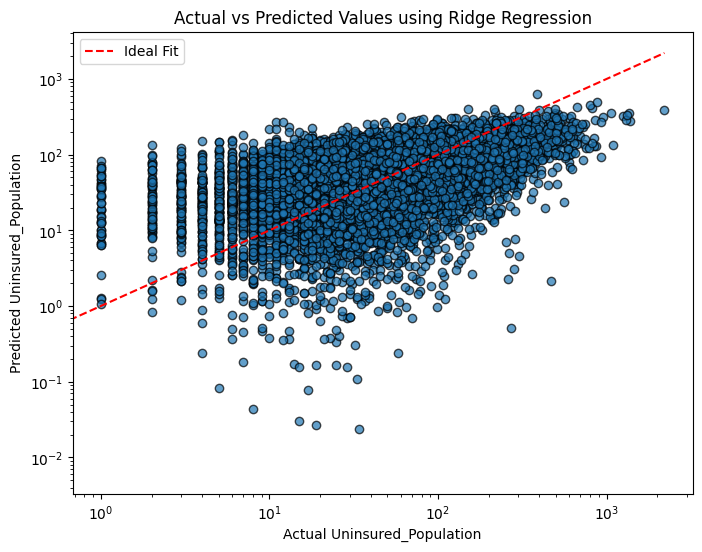

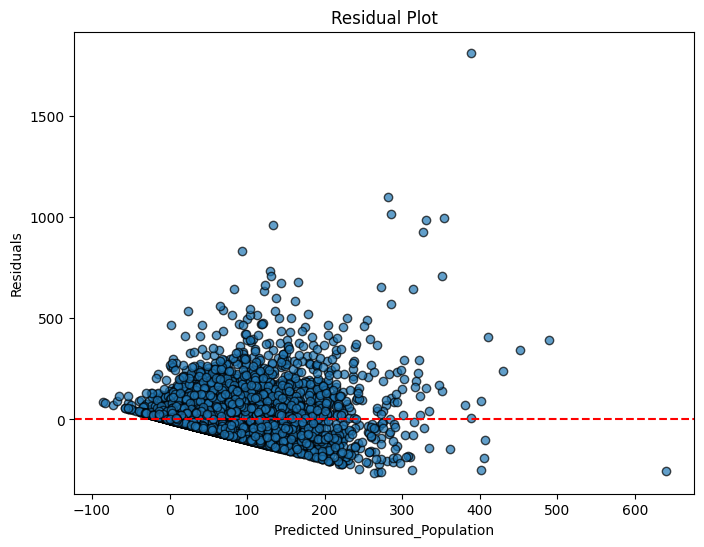

In [20]:
# Predict on test data (assuming y_test and y_pred from previous code)
y_pred = ridge.predict(X_test)

# Plot Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.xlabel("Actual Uninsured_Population")
plt.ylabel("Predicted Uninsured_Population")
plt.title("Actual vs Predicted Values using Ridge Regression")

# Plot reference line (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Ideal Fit")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# Alternatively, you could also plot residuals:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7, edgecolors='k')
plt.xlabel("Predicted Uninsured_Population")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [34]:
np.quantile(socioecon_clean['Uninsured_Population'], q=1)

np.int64(2370)

In [36]:
# Separate the target variable and the predictors
y = socioecon_clean['Uninsured_Population']
X = socioecon_clean.drop(columns=exclude_cols)

# Split the data into training and testing sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test R^2:", r2)
print("Test MSE:", mse)

# Optionally, check the feature importances
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

Test R^2: 0.38613740119020656
Test MSE: 4511.43370657263
                        Feature  Importance
8    Private_Insurance_Coverage    0.324544
12        Households_No_Vehicle    0.059802
19          Children_Population    0.056096
2         Unemployed_Population    0.035639
21             Black_Population    0.033241
1            Poverty_Population    0.033060
15      Renter_Occupied_Housing    0.032921
4               SNAP_Recipients    0.032667
6             Medicaid_Coverage    0.031142
3             Per_Capita_Income    0.030677
20             White_Population    0.030408
24       Households_No_Internet    0.029568
16    Rent_as_Income_Percentage    0.029097
9         High_School_Graduates    0.026418
14         Public_Transit_Usage    0.026228
11        Less_than_High_School    0.024519
0       Median_Household_Income    0.024080
18           Elderly_Population    0.023234
13                 Commute_Time    0.022479
7             Medicare_Coverage    0.019909
23  Limited_English

Overall:
- As predicted, multicollinearity is a major issue
- Regularization doesn't meaningfully improve the model's performance
- The random forest model is a marginal improvement over regression

In [40]:
gdf = gpd.read_file('./data/derivedData/census_with_healthcare_counts.geojson')

# Optionally, convert the geometry to a WKT string if you want to keep it in CSV
gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

# Write the GeoDataFrame to CSV (without the index)
gdf.to_csv('census_with_healthcare_counts.csv', index=False)

CSV file has been created.


/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_26410/1942529204.py:4: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)


In [47]:
gdf = gdf["GEOID"].astype(int)

In [49]:
socioecon_clean = pd.merge(socioecon_clean, gdf, on="GEOID", how="inner")